<p style="font-size:14px; text-align: right">CoastWatch Python Exercises</p>  

# Compare time series from different sensors

Several ocean color sensors have been launched since 1997 to provide continuous global coverage for ocean color data. The sensors have differences in design and calibration, and different algorithms may be applied to generate chlorophyll values. Consequently, chlorophyll-a values can vary among the sensors during periods where measurements overlap. 

To examine this phenomenon, we will download and plot time-series of chlorophyll-a concentrations from various sensors from 1997 to the present and see how the measurements compare during periods of overlap. 

## Objective
This tutorial will show how to extract a time-series from four different monthly satellite chlorophyll datasets for the period that each was in operation between 1997-present. 


## The tutorial demonstrates the following techniques
* Using xarray to extract data from a rectangular area of the ocean over time
* Retrieve information about a dataset from ERDDAP
* Comparing results from different sensors
* Averaging data spatially
* Producing timeseries plots
* Drawing maps with satellite data 

## Datasets used
SeaWiFS  Chlorophyll-a, V.2018, Monthly, Globsl, 4km, 1997-2012    
https://coastwatch.pfeg.noaa.gov/erddap/griddap/erdSW2018chlamday

MODIS Aqua, Chlorophyll-a, V.2022, Monthly, Globsl, 4km, 2002-present   
https://coastwatch.pfeg.noaa.gov/erddap/griddap/erdMH1chlamday_R2022SQ

NOAA VIIRS S-NPP, Chlorophyll-a, Monthly, Globsl, 4km, 2012-present     
https://coastwatch.noaa.gov/erddap/griddap/noaacwNPPVIIRSSQchlaMonthly

__ESA CCI Ocean Colour Dataset, v6.0, Monthly, Globsl, 4km, 1997-Present__   
This dataset was developed by the European Space Agency's Climate Change Initiative. The dataset is blends data from multiple sensors (MERIS, MODIS, VIIRS and SeaWiFS) to create a long timeseries (1997 to present) with better spatial coverage than any single sensor. Parameters include chlorophyll a, remote sensing reflectance, diffuse attenuation coefficients, absorption coefficients, backscatter coefficients, and water classification.  
https://coastwatch.pfeg.noaa.gov/erddap/griddap/pmlEsaCCI60OceanColorMonthly

## Import required packages

In [1]:
import xarray as xr 
import numpy as np 
from matplotlib import pyplot as plt 
from matplotlib.colors import LinearSegmentedColormap 
import matplotlib as mpl

The OceanWatch website has a data catalog containing documentation and links to all the datasets available:  
https://oceanwatch.pifsc.noaa.gov/doc.html

Navigate to the "Ocean Color" tab. From there you can access the different datasets using ERDDAP or THREDDS.

## Defined the area to extract
For each dataset we will extract data for an area in the Gulf of Mexico between -95 to -90°W longitude and 25-30°N latitude.

Set up variables with the minimum and maximum values from the longitude and latitude ranges


In [2]:
lon_min = -95.
lon_max = -90.
lat_min = 25.
lat_max = 30.

## Get the SeaWiFS data)
### Open a dataset object in xarray

In [3]:
url_sw = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/erdSW2018chlamday'
sw_ds = xr.open_dataset(url_sw)
sw_ds

<xarray.Dataset>
Dimensions:      (time: 157, latitude: 2160, longitude: 4320)
Coordinates:
  * time         (time) datetime64[ns] 1997-09-16 1997-10-16 ... 2010-12-16
  * latitude     (latitude) float32 89.96 89.88 89.79 ... -89.79 -89.88 -89.96
  * longitude    (longitude) float32 -180.0 -179.9 -179.8 ... 179.8 179.9 180.0
Data variables:
    chlorophyll  (time, latitude, longitude) float32 ...
Attributes: (12/50)
    _lastModified:                     2018-01-31T04:58:26.000Z
    _NCProperties:                     version=1|netcdflibversion=4.4.1.1|hdf...
    cdm_data_type:                     Grid
    Conventions:                       CF-1.6, COARDS, ACDD-1.3
    creator_email:                     data@oceancolor.gsfc.nasa.gov
    creator_name:                      NASA/GSFC/OBPG
    ...                                ...
    summary:                           NASA GSFC Ocean Color Web distributes ...
    temporal_range:                    10-day
    time_coverage_end:                 2010-12-16T00:00:00Z
    time_coverage_start:               1997-09-16T00:00:00Z
    title:                             Chlorophyll-a, Orbview-2 SeaWiFS, R201...
    Westernmost_Easting:               -179.9583

### Print out some metadata
You can view all of the metadata above in the sw_ds Xarray dataset object. Let's print out some metadata items to point a few thing out below:
* The SeaWiFS dataset spans 13 years, from 1997 to 2010  
* The chlorophyll data is called "chlorophyll". Knowing this is important because variable names are not standardized, and we will need to know the exact variable name to extract the data. 

In [4]:
print('earliest date =', sw_ds.time.values[0])
print('most recent date =', sw_ds.time.values[-1], '\n')
print('variables:', list(sw_ds.data_vars.keys()), '\n')

print('Is the first latitude value -->', round(sw_ds.latitude[0].item(), 6))
print('greater than the last latitude value -->', round(sw_ds.latitude[-1].item(), 6))

sw_ds.latitude[0].item() > sw_ds.latitude[-1].item()



earliest date = 1997-09-16T00:00:00.000000000
most recent date = 2010-12-16T00:00:00.000000000 

variables: ['chlorophyll'] 

Is the first latitude value --> 89.958336
greater than the last latitude value --> -89.958336


True

### Pay attention to the first and last values on latitude in the dataset
In a netCDF file that completely follows accepted standards, the latitude values are ascending, the values go from lowest to highest. Therefore, when we use slice below to subset the dataset, normally we would insert the lowest value in our subset followed by the highest  
* slice(lat_min, lat_min)  

However, the latitude values are descending in this dataset. 
* The first latitude value (89.958336) is greater than the last (-89.958336). See above.
Using "slice(lat_min, lat_min)" will get you no data, because __there are no values between lat_min and lat_max__ 
Instead, __there are values between lat_max and lat_min.__  

There are methods in xarray to flip the latitude dimension. 
* However, for this exercise a simpler solution is to use a logic step that determines if latitude values are descending, then set slice values to use the larger value first (see below).   


In [5]:
lat1 = lat_min
lat2 = lat_max

if sw_ds.latitude[0].item() > sw_ds.latitude[-1].item():
    lat1 = lat_max
    lat2 = lat_min

### Use xarray to extract the data from the downloaded file and print information about the data variables.

In [6]:

sw_subset = sw_ds['chlorophyll'].sel(time=slice(sw_ds.time[0], sw_ds.time[-1]),
                                     latitude=slice(lat1, lat2),
                                     longitude=slice(lon_min, lon_max)
                                     )
sw_subset

<xarray.DataArray 'chlorophyll' (time: 157, latitude: 60, longitude: 60)>
[565200 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1997-09-16 1997-10-16 ... 2010-12-16
  * latitude   (latitude) float32 29.96 29.87 29.79 29.71 ... 25.21 25.12 25.04
  * longitude  (longitude) float32 -94.96 -94.88 -94.79 ... -90.21 -90.12 -90.04
Attributes:
    colorBarMaximum:  30.0
    colorBarMinimum:  0.03
    colorBarScale:    Log
    ioos_category:    Ocean Color
    long_name:        Chlorophyll Concentration, OCI Algorithm
    references:       Hu, C., Lee Z., and Franz, B.A. (2012). Chlorophyll-a a...
    standard_name:    concentration_of_chlorophyll_in_sea_water
    units:            mg m^-3
    valid_max:        100.0
    valid_min:        0.001

### Plot data to show where it is in the world.

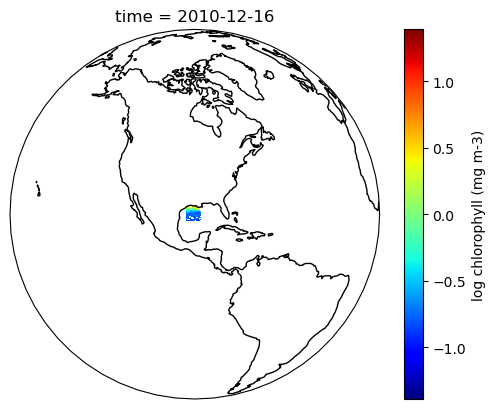

In [7]:
import cartopy.crs as ccrs


ax = plt.axes(projection=ccrs.Orthographic(-92, 27))
ax.set_global()
np.log10(sw_subset[-1]).plot.pcolormesh(ax=ax, 
                                        transform=ccrs.PlateCarree(), 
                                        cbar_kwargs={'label': "log chlorophyll (mg m-3)"},
                                        cmap="jet")

ax.coastlines()

The downloaded data contains only one variable: chlor_a.  
    
### Compute the monthly mean over the region
* Extract the dates corresponding to each month, too

In [8]:
swAVG = sw_subset.mean(dim=['latitude','longitude'])
swAVG.head()

# if you are rumming low on memory, uncomment the next line
# del sw_subset

<xarray.DataArray 'chlorophyll' (time: 5)>
array([0.59386134, 0.59238297, 0.68359953, 0.81557316, 0.85900825],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1997-09-16 1997-10-16 ... 1998-01-16

## Get monthly MODIS data
### Repeat the steps above to get data for the MODIS Aqua chlorophyll dataset 


In [9]:
url_modis = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/erdMH1chlamday_R2022SQ'
modis_ds = xr.open_dataset(url_modis)
modis_ds

print('earliest date =', modis_ds.time.values[0])
print('latest date =', modis_ds.time.values[-1], '\n')
print('variables:', modis_ds.data_vars.keys(), '\n')
print('Is the first latitude value -->', modis_ds.latitude[0].item())
print('greater than the last latitude value -->', modis_ds.latitude[-1].item())

lat1 = lat_min
lat2 = lat_max

if modis_ds.latitude[0].item() > modis_ds.latitude[-1].item():
    lat1 = lat_max
    lat2 = lat_min

modis_subset = modis_ds['chlor_a'].sel(time=slice(modis_ds.time[0], modis_ds.time[-1]),
                                       latitude=slice(lat1, lat2),
                                       longitude=slice(lon_min, lon_max)
                                       )

modisAVG = modis_subset.mean(dim=['latitude','longitude'])

# if you are rumming low on memory, uncomment the next line
# del modis_subset 


earliest date = 2002-07-16T00:00:00.000000000
latest date = 2023-05-16T00:00:00.000000000 

variables: KeysView(Data variables:
    chlor_a  (time, latitude, longitude) float32 ...) 

Is the first latitude value --> 89.97916412353516
greater than the last latitude value --> -89.97917175292969


## Get monthly VIIRS data
### Repeat the steps above to get data for the VIIRS SNPP chlorophyll dataset


In [10]:
url_viirs = 'https://coastwatch.noaa.gov/erddap/griddap/noaacwNPPVIIRSSQchlaMonthly'
viirs_ds = xr.open_dataset(url_viirs)
viirs_ds

print('earliest date =', viirs_ds.time.values[0])
print('latest date =', viirs_ds.time.values[-1], '\n')
print('variables:', viirs_ds.data_vars.keys(), '\n')

print('Is the first latitude value -->', viirs_ds.latitude[0].item())
print('greater than the last latitude value -->', viirs_ds.latitude[-1].item())

lat1 = lat_min
lat2 = lat_max

if viirs_ds.latitude[0].item() > viirs_ds.latitude[-1].item():
    lat1 = lat_max
    lat2 = lat_min

viirs_subset = modis_ds['chlor_a'].sel(time=slice(viirs_ds.time[0], viirs_ds.time[-1]),
                                       latitude=slice(lat1, lat2),
                                       longitude=slice(lon_min, lon_max)
                                       )
viirsAVG = viirs_subset.mean(dim=['latitude','longitude'])

# if you are rumming low on memory, uncomment the next line
# del viirs_subset 


earliest date = 2012-01-02T12:00:00.000000000
latest date = 2023-07-01T12:00:00.000000000 

variables: KeysView(Data variables:
    chlor_a  (time, altitude, latitude, longitude) float32 ...) 

Is the first latitude value --> 89.75625
greater than the last latitude value --> -89.75625


## Plot time series
### Plot the result for three datasets 

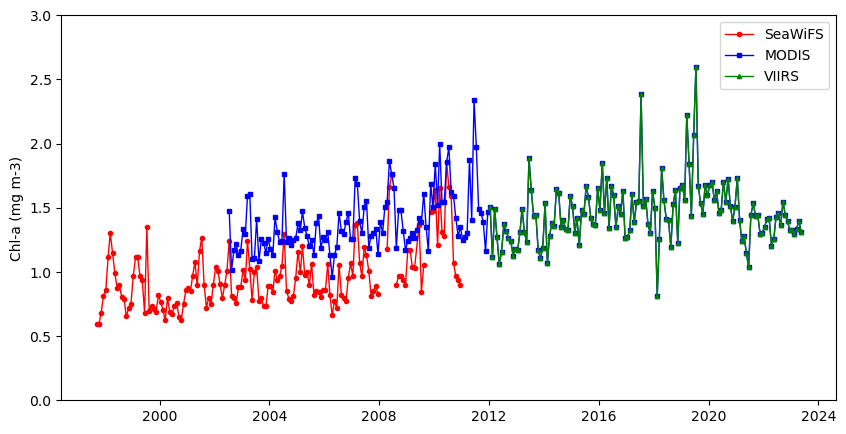

In [11]:
plt.figure(figsize = (10, 5)) 
# Plot the SeaWiFS data
plt.plot_date(swAVG.time, swAVG, 
              'o', markersize=3, 
              label='SeaWiFS', c='red', 
              linestyle='-', linewidth=1) 

# Add MODIS data
plt.plot_date(modisAVG.time, modisAVG, 
              's', markersize=3, 
              label='MODIS', c='blue', 
              linestyle='-', linewidth=1) 

# Add VIIRS data
plt.plot_date(viirsAVG.time, viirsAVG, 
              '^', markersize=3, 
              label='VIIRS', c='green', 
              linestyle='-', linewidth=1) 

plt.ylim([0, 3])
plt.ylabel('Chl-a (mg m-3)') 
plt.legend()

## Get OC-CCI data
If you needed a single time series from 1997 to present, you would have to use the plot above to devise some method to reconcile the difference in values where two datasets overlap. Alternatively, you could use the ESA OC-CCI (ocean color climate change initiative) dataset, which blends data from many satellite missions into a single dataset, including data from SeaWiFS, MODIS, and VIIRS. 

Add the ESA OC-CCI dataset to the plot above to see how it compares with data from the individual satellite missions.  
### Repeat the steps above to get data from the ESA OC-CCI chlorophyll dataset 

In [12]:
url_cci = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/pmlEsaCCI60OceanColorMonthly'
cci_ds = xr.open_dataset(url_cci)
cci_ds

print('earliest date =', cci_ds.time.values[0])
print('latest date =', cci_ds.time.values[-1])

# From the 93 variables in the dataset, dysplay only those with chl in the name
subset_variables = [ln for ln in list(cci_ds.data_vars.keys()) if 'chl' in ln]

print('variables with chl in name:', subset_variables, '\n')


print('Is the first latitude value -->', cci_ds.latitude[0].item())
print('greater than the last latitude value -->', cci_ds.latitude[-1].item())

lat1 = lat_min
lat2 = lat_max

if cci_ds.latitude[0].item() > cci_ds.latitude[-1].item():
    lat1 = lat_max
    lat2 = lat_min

cci_subset = cci_ds['chlor_a'].sel(time=slice(cci_ds.time[0], cci_ds.time[-1]),
                                   latitude=slice(lat1, lat2),
                                   longitude=slice(lon_min, lon_max)
                                   )
cciAVG = cci_subset.mean(dim=['latitude','longitude'])

# if you are rumming low on memory, uncomment the next line
# del cci_subset 

earliest date = 1997-09-04T00:00:00.000000000
latest date = 2023-03-01T00:00:00.000000000
variables with chl in name: ['chlor_a', 'chlor_a_log10_bias', 'chlor_a_log10_rmsd'] 

Is the first latitude value --> 89.97916666666667
greater than the last latitude value --> -89.97916666666666


## Replot the result using data from all four datasets 


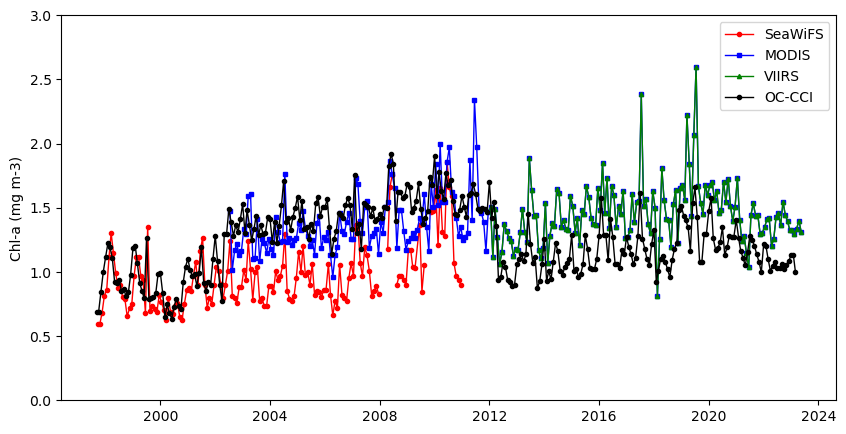

In [13]:
plt.figure(figsize = (10, 5)) 

# Add SeaWiFS data
plt.plot_date(swAVG.time, swAVG, 
              'o', markersize=3, 
              label='SeaWiFS', c='red', 
              linestyle='-', linewidth=1) 

# Add MODIS data
plt.plot_date(modisAVG.time, modisAVG, 
              's', markersize=3, 
              label='MODIS', c='blue', 
              linestyle='-', linewidth=1) 

# Add VIIRS data
plt.plot_date(viirsAVG.time, viirsAVG, 
              '^', markersize=3, 
              label='VIIRS', c='green', 
              linestyle='-', linewidth=1) 

# Add CCI data
plt.plot_date(cciAVG.time, cciAVG, 
              '.', 
              label='OC-CCI', c='black', 
              linestyle='-', linewidth=1) 

plt.ylim([0, 3])
plt.ylabel('Chl-a (mg m-3)') 
plt.legend()